In [1]:
import os
import librosa
import IPython.display as ipd
import matplotlib.pyplot as plt
import numpy as np
from scipy.io import wavfile
import warnings

warnings.filterwarnings("ignore")

In [2]:
import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import matplotlib. pyplot as plt
from IPython import display
from jiwer import wer

In [3]:
gpus = tf.config.experimental.list_physical_devices('GPU')

for gpu in gpus:
    tf.config.experimental.set_memory_growth(gpu, True)
    tf.config.experimental.set_virtual_device_configuration(gpu, [tf.config.experimental.VirtualDeviceConfiguration(memory_limit=1024*4)])

In [4]:
data_path = "C:/Documents/IS/IS bareng DIFFFFFFFFFFF/audio/LJSpeech-1.1/LJSpeech-1.1"

In [5]:
wavs_path = data_path + "/wavs/"
metadata_path = data_path + "/metadata.csv"

In [6]:
metadata_df = pd.read_csv(metadata_path, sep= "|", header=None, quoting=3)

In [7]:
metadata_df.head(10)

,0,1,2
0,LJ001-0001,"Printing, in the only sense with which we are ...","Printing, in the only sense with which we are ..."
1,LJ001-0002,in being comparatively modern.,in being comparatively modern.
2,LJ001-0003,For although the Chinese took impressions from...,For although the Chinese took impressions from...
3,LJ001-0004,"produced the block books, which were the immed...","produced the block books, which were the immed..."
4,LJ001-0005,the invention of movable metal letters in the ...,the invention of movable metal letters in the ...
5,LJ001-0006,"And it is worth mention in passing that, as an...","And it is worth mention in passing that, as an..."
6,LJ001-0007,"the earliest book printed with movable types, ...","the earliest book printed with movable types, ..."
7,LJ001-0008,has never been surpassed.,has never been surpassed.
8,LJ001-0009,"Printing, then, for our purpose, may be consid...","Printing, then, for our purpose, may be consid..."
9,LJ001-0010,"Now, as all books not primarily intended as pi...","Now, as all books not primarily intended as pi..."


In [8]:
metadata_df.columns = ["file_name", "transcription", "normalized_transcription"]
metadata_df = metadata_df[["file_name", "transcription", "normalized_transcription"]]
metadata_df = metadata_df.sample(frac=1).reset_index(drop=True)
metadata_df.head(3)

,file_name,transcription,normalized_transcription
0,LJ027-0042,All such cases of resemblance in function but ...,All such cases of resemblance in function but ...
1,LJ019-0316,Hard labor of the first and second class was c...,Hard labor of the first and second class was c...
2,LJ028-0212,On the night of the eleventh day Gobrias kille...,On the night of the eleventh day Gobrias kille...


In [9]:
split = int(len(metadata_df) * 0.90)
df_train = metadata_df[:3000]
df_val = metadata_df[3000:3300]

print(f"Size of the training set: {len(df_train)}")
print(f"Size of the training set: {len(df_val)}")

Size of the training set: 3000
Size of the training set: 300


In [10]:
characters = [x for x in "abcdefghijklmnopqrstuvwxyz"]

char_to_num = keras.layers.StringLookup(vocabulary=characters, oov_token="")

num_to_char = keras.layers.StringLookup(vocabulary=char_to_num.get_vocabulary(), oov_token="", invert=True)

print(
    f"The Vocabulary is: {char_to_num.get_vocabulary()}"
    f"Size = {char_to_num.vocabulary_size()}"
)

The Vocabulary is: ['', 'a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j', 'k', 'l', 'm', 'n', 'o', 'p', 'q', 'r', 's', 't', 'u', 'v', 'w', 'x', 'y', 'z']Size = 27


In [11]:
char_to_num

In [12]:
frame_length = 256
frame_step = 160
fft_length = 384

def encode_single_sample(wav_file, label):
  file = tf.io.read_file(wavs_path + wav_file + ".wav")
  audio, _ = tf.audio.decode_wav(file)
  audio = tf.squeeze(audio, axis= -1)
  audio = tf.cast(audio, tf.float32)
  spectogram = tf.signal.stft(
      audio, frame_length=frame_length, frame_step=frame_step, fft_length=fft_length
  )
  spectrogram = tf.abs(spectogram)
  spectrogram = tf.math.pow(spectrogram, 0.5)

  means = tf.math.reduce_mean(spectrogram, 1 , keepdims=True)
  stddevs = tf.math.reduce_std(spectrogram, 1 , keepdims=True)
  spectrogram = (spectrogram - means)/ (stddevs + 1e-10)

  label = tf.strings.lower(label)
  label = tf.strings.unicode_split(label, input_encoding="UTF-8")
  label = char_to_num(label)

  return spectrogram, label

In [13]:
batch_size = 32

train_dataset = tf.data.Dataset.from_tensor_slices(
    (list(df_train["file_name"]), list(df_train["normalized_transcription"]))
)

train_dataset = (
    train_dataset.map(encode_single_sample, num_parallel_calls=tf.data.AUTOTUNE)
    .padded_batch(batch_size)
    .prefetch(buffer_size=tf.data.AUTOTUNE)
)

validation_dataset = tf.data.Dataset.from_tensor_slices(
    (list(df_val["file_name"]), list(df_val["normalized_transcription"]))
)

validation_dataset = (
    validation_dataset.map(encode_single_sample, num_parallel_calls=tf.data.AUTOTUNE)
    .padded_batch(batch_size)
    .prefetch(buffer_size=tf.data.AUTOTUNE)
)

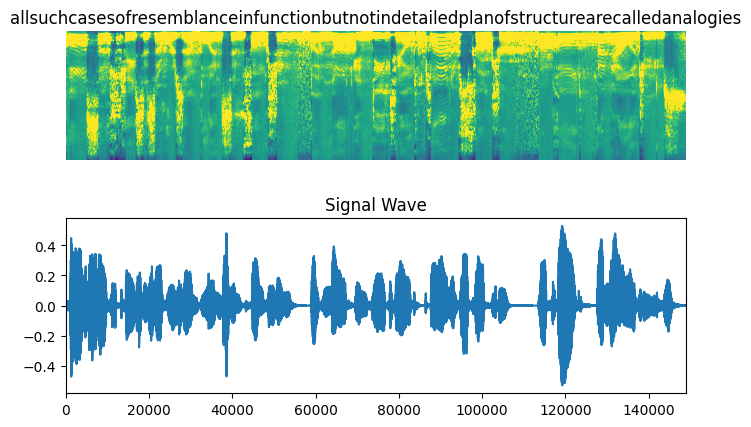

In [14]:
fig = plt.figure(figsize=(8,5))
for batch in  train_dataset.take(1):
    spectogram = batch[0][0].numpy()
    spectogram = np.array([np.trim_zeros(x) for x in np.transpose(spectogram)])
    label = batch[1][0]

    label = tf.strings.reduce_join(num_to_char(label)).numpy().decode("utf-8")
    ax = plt.subplot(2, 1, 1)
    ax.imshow(spectogram, vmax=1)
    ax.set_title(label)
    ax.axis("off")

    file = tf.io.read_file(wavs_path + list(df_train["file_name"])[0] + ".wav")
    audio, _ = tf.audio.decode_wav(file)
    auio = audio.numpy()
    ax = plt.subplot(2, 1, 2)
    plt.plot(audio)
    ax.set_title("Signal Wave")
    ax.set_xlim(0, len(audio))
    display.display(display.Audio(np.transpose(audio), rate=16000))
plt.show()

In [15]:
def CTCLoss(y_true, y_pred):
  batch_len = tf.cast(tf.shape(y_true)[0], dtype="int64")
  input_length = tf.cast(tf.shape(y_pred)[1], dtype="int64")
  label_length = tf.cast(tf.shape(y_true)[1], dtype="int64")

  input_length = input_length * tf.ones(shape=(batch_len, 1 ), dtype="int64")
  label_length = label_length * tf.ones(shape=(batch_len, 1 ), dtype="int64")

  loss = keras.backend.ctc_batch_cost(y_true, y_pred, input_length, label_length)
  return loss

In [16]:

def build_model(input_dim, output_dim, rnn_layers=5, rnn_units=128):
  input_spectrogram =layers.Input((None, input_dim), name="input")

  x = layers.Reshape((-1, input_dim , 1), name="expand_dim")(input_spectrogram)

  x = layers.Conv2D(
      filters=32,
      kernel_size=[11, 61],
      strides=[2,2],
      padding="same",
      use_bias=False,
      name="conv_1",
  )(x)
  x = layers.BatchNormalization(name="conv_1_bn")(x)
  x = layers.ReLU(name="conv_1_relu")(x)

  x = layers.Conv2D(
      filters=32,
      kernel_size=[11, 41],
      strides=[2,2],
      padding="same",
      use_bias=False,
      name="conv_2",
  )(x)
  x = layers.BatchNormalization(name="conv_2_bn")(x)
  x = layers.ReLU(name="conv_2_relu")(x)

  x = layers.Reshape((-1, x.shape[-2] * x.shape[-1]))(x)

  for i in range(1, rnn_layers + 1):
    recurrent = layers.GRU(
        units=rnn_units,
        activation="tanh",
        recurrent_activation="sigmoid",
        use_bias=True,
        return_sequences=True,
        reset_after=True,
        name=f"gru_{i}",
    )
    x = layers.Bidirectional(
        recurrent, name=f"bidirectional_{i}", merge_mode="concat"
    )(x)

    if i < rnn_layers:
      x = layers.Dropout(rate=0.5)(x)

    x = layers.Dense(units=rnn_units * 2, name="dense_1")(x)
    x = layers.ReLU(name="dense_relu")(x)
    x = layers.Dropout(rate=0.5)(x)

    output = layers.Dense(units=output_dim + 1, activation="softmax")(x)

    model = keras.Model(input_spectrogram, output, name="SpeechToText")

    opt = keras.optimizers.Adam(learning_rate=1e-4)

    model.compile(optimizer=opt, loss=CTCLoss)

    return model

model = build_model(
    input_dim = fft_length // 2 + 1,
    output_dim = char_to_num.vocabulary_size(),
    rnn_units=512,
)

model.summary(line_length=110)

Model: "SpeechToText"
______________________________________________________________________________________________________________
 Layer (type)                                    Output Shape                                Param #          
 input (InputLayer)                              [(None, None, 193)]                         0                
                                                                                                              
 expand_dim (Reshape)                            (None, None, 193, 1)                        0                
                                                                                                              
 conv_1 (Conv2D)                                 (None, None, 97, 32)                        21472            
                                                                                                              
 conv_1_bn (BatchNormalization)                  (None, None, 97, 32)                     

In [17]:
def decode_batch_predictions(pred):
    input_len = np.ones(pred.shape[0]) * pred.shape[1]

    results = keras.backend.ctc_decode(pred, input_length=input_len, greedy=True)[0][0]

    output_text = []
    for result in results:
        result = tf.strings.reduce_join(num_to_char(result)).numpy().decode("utf-8")
        output_text.append(result)
    return output_text

class CallbackEval(keras.callbacks.Callback):

    def __init__(self, dataset):
        super().__init__()
        self.dataset = dataset
      
    def on_epoch_end(self, epoch: int, logs=None):
        predictions = []
        targets = []

        for batch in self.dataset:
          X, y = batch
          batch_predictions = model.predict(X)
          batch_predictions = decode_batch_predictions(batch_predictions)
          predictions.extend(batch_predictions)

          for label in y:
              label = (tf.strings.reduce_join(num_to_char(label)).numpy().decode("utf-8"))
              targets.append(label)
        wer_score = wer(targets, predictions)
        print("-" * 100)
        print(f"Word Error Rate: {wer_score:.4f}")
        print("-" * 100)
        for i in np.random.randint(0, len(predictions), 5):
            print(f"Targets     : {targets[i]}")
            print(f"Predictions : {predictions[i]}")
            print("-" * 100)

In [18]:
validation_dataset

<PrefetchDataset element_spec=(TensorSpec(shape=(None, None, 193), dtype=tf.float32, name=None), TensorSpec(shape=(None, None), dtype=tf.int64, name=None))>

In [19]:
epochs = 50

validation_callback = CallbackEval(validation_dataset)

tf.debugging.set_log_device_placement(True)

history = model.fit(
    train_dataset,
    validation_data = validation_dataset,
    epochs = epochs,
    callbacks=[validation_callback],
)


Epoch 1/50
1/1 [==============================] - 1s 554ms/step
----------------------------------------------------------------------------------------------------
Word Error Rate: 1.0000
----------------------------------------------------------------------------------------------------
Targets     : itisanableandexhaustivestatepapertestifyingtothekeennessofthewritersperceptionandhisunremittinglaborinpursuinghisresearches
Predictions : 
----------------------------------------------------------------------------------------------------
Targets     : thislatterwasanordealwhichalldreadedandmanyavoidedbydenyingtheirfaith
Predictions : 
----------------------------------------------------------------------------------------------------
Targets     : hadinvariablybeenvisitedwiththedeathpenaltyandwhichwasofadistinctlyfraudulentnature
Predictions : 
----------------------------------------------------------------------------------------------------
Targets     : thattheonlyreasonableexplana

1/1 [==============================] - 0s 132ms/step
----------------------------------------------------------------------------------------------------
Word Error Rate: 1.0000
----------------------------------------------------------------------------------------------------
Targets     : onhisreleasehesentachallengetolordsidmouththehomesecretaryandwasagainarrestedandimprisoned
Predictions : t
----------------------------------------------------------------------------------------------------
Targets     : andmostoftherecordswhichhavecomefromhistimespeakchieflyofhisdeedsofpiety
Predictions : ah
----------------------------------------------------------------------------------------------------
Targets     : tomayfourteennineteensixtythree
Predictions : tee
----------------------------------------------------------------------------------------------------
Targets     : noseriousimportancecouldbeattachedtothesethemanifestinventionsofadisorderedintellect
Predictions : the
------------

Epoch 10/50
1/1 [==============================] - 0s 126ms/step
----------------------------------------------------------------------------------------------------
Word Error Rate: 1.0000
----------------------------------------------------------------------------------------------------
Targets     : monitororschoolmasternortobeengagedintheserviceofanyofficeroftheprison
Predictions : woeroeseeeoeeietoeeeee
----------------------------------------------------------------------------------------------------
Targets     : thatinthemetropolisofthishighlyfavoredcountrytowhichtheeyesofotherlandsturnforexampleasystemofprisondisciplinesuchasthatenforcedinnewgate
Predictions : anoooeoeieso
----------------------------------------------------------------------------------------------------
Targets     : nothingbutbeatinghempandpullingoakumandpoundingbricksnoworkbutwhatwastediousunusual
Predictions : ahaoooloooeoeooee
----------------------------------------------------------------------------

Epoch 14/50
1/1 [==============================] - 0s 131ms/step
----------------------------------------------------------------------------------------------------
Word Error Rate: 1.0000
----------------------------------------------------------------------------------------------------
Targets     : whereupontheywithdrewwithintheirdefenses
Predictions : wrernineffoereeehe
----------------------------------------------------------------------------------------------------
Targets     : inseventeeneightynineinlesstimethanittookgeorgewashingtontotravelfromnewyorktomountvernon
Predictions : ihnsetenahnlasonhindthtotorpolhontinthrfroeeee
----------------------------------------------------------------------------------------------------
Targets     : afterhereturnedtotheunitedstates
Predictions : afetetoretetiet
----------------------------------------------------------------------------------------------------
Targets     : whichgrowsasonespeakstohimendquote
Predictions : thoososoeoene

Epoch 18/50
1/1 [==============================] - 0s 141ms/step
----------------------------------------------------------------------------------------------------
Word Error Rate: 1.0000
----------------------------------------------------------------------------------------------------
Targets     : themomentitwasdiscoveredthatthediamondshaddisappearedtheaffairwastakenupbythepolice
Predictions : themomtietdefowasisordthatthednmnsendisopcerthefwstainoh
----------------------------------------------------------------------------------------------------
Targets     : thebottomofthepalmrestedonthebox
Predictions : thbohemotheporesto
----------------------------------------------------------------------------------------------------
Targets     : theoccupantsofthisterribleblackpewwerethelastalwaystoenterthechapel
Predictions : hectnsofthistarbaeblhwrthelsalwrstentot
----------------------------------------------------------------------------------------------------
Targets     : wieders

Epoch 22/50
1/1 [==============================] - 0s 265ms/step
----------------------------------------------------------------------------------------------------
Word Error Rate: 1.0000
----------------------------------------------------------------------------------------------------
Targets     : thedietofthecondemnedistheordinarydietoftheprison
Predictions : thedidofthecondemdistherdnaridiofthprison
----------------------------------------------------------------------------------------------------
Targets     : euinswhowasonthesouthwestcornerofelmandhoustonstreetstestifiedthathecouldnotdescribethemanhesawinthewindow
Predictions : nshowasonthesohwhisqornervbelminchestnstrtestifiththecoenottisfrthemandhe
----------------------------------------------------------------------------------------------------
Targets     : soldoutsolargeanamountofstockthathepaidsixteenthousandpoundsayearindividendstoescapedetection
Predictions : solotsolortonamontostoththecasiendhosonpnsayrinddnstoiet

Epoch 26/50
1/1 [==============================] - 0s 290ms/step
----------------------------------------------------------------------------------------------------
Word Error Rate: 1.0000
----------------------------------------------------------------------------------------------------
Targets     : guinyardclaimedthatthemanrandowntheeastsideofpattonandpassedwithintenfeetofhimbeforecrossingtotheotherside
Predictions : ghimerdclamdthatthemandrandommhesidfpatanpaswithentenfetonfvhimeforcrosontotheoe
----------------------------------------------------------------------------------------------------
Targets     : associationatonetimeforbiddenbycustombutwhichgreedandrapacitylongmadetherule
Predictions : asuyationatwontiefrmbidbiycoustubhewhichcoredanbrerpasitylonma
----------------------------------------------------------------------------------------------------
Targets     : brennandescribedtothepolicethemanhesawinthewindowandthenidentifiedoswaldasthepersonwhomostnearlyresembledthem

Epoch 30/50
1/1 [==============================] - 0s 119ms/step
----------------------------------------------------------------------------------------------------
Word Error Rate: 1.0000
----------------------------------------------------------------------------------------------------
Targets     : inasmuchasthefactsrelatingtooswaldsactivitiesatthattimedidnotwarrantsuchaction
Predictions : inismuhisthefintsrelatingtooswaldactivitesatthattiedidnotwarseco
----------------------------------------------------------------------------------------------------
Targets     : itwasthatofanagedmanwhoseheadhadbeenbatteredinbyalifepreserver
Predictions : itwasthathavanaeddmancomsthadhadbinbaterdinbyelirr
----------------------------------------------------------------------------------------------------
Targets     : whereupontheywithdrewwithintheirdefenses
Predictions : wherponaywihtderowivthintherdifense
----------------------------------------------------------------------------------------

Epoch 34/50
1/1 [==============================] - 0s 132ms/step
----------------------------------------------------------------------------------------------------
Word Error Rate: 1.0000
----------------------------------------------------------------------------------------------------
Targets     : itisclearthatthenotewaswrittenwhiletheoswaldswerelivingindallasbeforetheymovedtoneworleansinthespringofnineteensixtythree
Predictions : itisclarethathenosoritowaltlyoswldswallivingindalasbuafortthymovttonorlensintssperingofninetext
----------------------------------------------------------------------------------------------------
Targets     : recordsofseaporttradersincorporatedamailorderdivisionofgeorgeroseandco
Predictions : reersofseeportraersancourperiadhamalorderddvisionoofjordrosinco
----------------------------------------------------------------------------------------------------
Targets     : becausetheyarenotspecifiedinhissentenceheisthereforeentitledtoawholesomeatmosphere
P

Epoch 38/50
1/1 [==============================] - 0s 141ms/step
----------------------------------------------------------------------------------------------------
Word Error Rate: 1.0000
----------------------------------------------------------------------------------------------------
Targets     : soldoutsolargeanamountofstockthathepaidsixteenthousandpoundsayearindividendstoescapedetection
Predictions : suldoutsolargonamountofstothathecadsextendousonponsayearindivedensto
----------------------------------------------------------------------------------------------------
Targets     : previoustotheexecutionofhenryfauntleroyforutteringaforgedsecurity
Predictions : prevustotheexecutionofhandrefoharonforuheringofforgedsoury
----------------------------------------------------------------------------------------------------
Targets     : thepressuresoonbecamesofrightfulthatmanywouldhavewillinglyescapedfromthecrowdbuttheirattemptsonlyincreasedthegeneralconfusion
Predictions : thepresur

Epoch 42/50
1/1 [==============================] - 0s 122ms/step
----------------------------------------------------------------------------------------------------
Word Error Rate: 1.0000
----------------------------------------------------------------------------------------------------
Targets     : agentlawsonsinterimreportwasreceivedbyagentkellermanonnovembertwentythedaybeforedepartureonthetexastrip
Predictions : hgentlasnnsinturmerportwasrecevbygagenculermianonnovembertwentythedadbefordeparturonthetecxxtr
----------------------------------------------------------------------------------------------------
Targets     : andyetthisdoctrinerequirestheutmostutmostrestraintastateofbeinginitselfmajesticinpowerendquote
Predictions : andtthisdotrindequiretheyoutmosotmoshrstraastatofeinginitselfmidjestiinpoo
----------------------------------------------------------------------------------------------------
Targets     : theairtowhichtheleavesareexposedcontainscarbon
Predictions : thertow

Epoch 46/50
1/1 [==============================] - 0s 139ms/step
----------------------------------------------------------------------------------------------------
Word Error Rate: 1.0000
----------------------------------------------------------------------------------------------------
Targets     : theotherswouldhavebeenabletoreducetheirtimesiftheyhadbeengiventheopportunitytobecomefamiliarwiththemovementoftheboltandthetriggerpull
Predictions : theethrswoevbenabletoredducthertimesittheyhadingigtheopreunitytobecomfimilyrwithemovmetoftheboandthatrirpll
----------------------------------------------------------------------------------------------------
Targets     : sirjohndeanpaulhadinheritedabaronetcyfromhisfathertogetherwithanhonoredname
Predictions : scerdjondenalhadinherentendabarinitseyfromhisfotertogewithanoerdna
----------------------------------------------------------------------------------------------------
Targets     : onthefourteenthdaysipparwastakenwithoutabattle
Predi

Epoch 50/50
1/1 [==============================] - 0s 196ms/step
----------------------------------------------------------------------------------------------------
Word Error Rate: 0.9967
----------------------------------------------------------------------------------------------------
Targets     : hadinvariablybeenvisitedwiththedeathpenaltyandwhichwasofadistinctlyfraudulentnature
Predictions : hatinvearyadlybenvisitedtwiththedettphenltyandwhachwaspoodestingtlyttrodgulentnaahr
----------------------------------------------------------------------------------------------------
Targets     : thattheonlyreasonableexplanationfortheexistenceofafundamentalunityinorganiclife
Predictions : thatheolyreasonbleexplnationfrheexistencsoarffunimentollunityeanorganeclie
----------------------------------------------------------------------------------------------------
Targets     : cliftonccarterridinginthevicepresidentsfollowupcarashortdistancebehind
Predictions : citinceseecarterridinithevice

In [20]:
predictions = []
targets = []
for batch in validation_dataset:
    X, y = batch 
    batch_predictions = model.predict(X)
    batch_predictions = decode_batch_predictions(batch_predictions)
    predictions.extend(batch_predictions)

    for label in y:
        label = tf.strings.reduce_join(num_to_char(label)).numpy().decode("utf-8")
        targets.append(label)

wer_score = wer(targets, predictions)
print("-" * 100)
print(f"Word Error Rate: {wer_score:.4f}")
print("-" * 100)
for i in np.random.randint(0, len(predictions), 5):
    print(f"Targets     : {targets[i]}")
    print(f"Predictions : {predictions[i]}")
    print("-" * 100)

1/1 [==============================] - 0s 96ms/step
----------------------------------------------------------------------------------------------------
Word Error Rate: 0.9967
----------------------------------------------------------------------------------------------------
Targets     : thecrowdvociferouslyyelledtheirdisapprovalandatlength
Predictions : thecroudworsefrucslyelttherdoscurovlandatlene
----------------------------------------------------------------------------------------------------
Targets     : thegovernorinsistedbutcourvoisiershowedgreatreluctancetostrip
Predictions : theornerinsistebutcovesiatiogreatraleoctedstr
----------------------------------------------------------------------------------------------------
Targets     : hetoldtheexecutionertodoittidytopullittightandwasinastateofhystericalexaltationuptotheverylast
Predictions : hetoltheexecutinertwodoitctieetopolitightanwasinesstakeofhistericalexeltationothee
--------------------------------------------------